In [253]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction import text
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
import string

#modules for n-gram model
#warnings ot surpressed
import tensorflow as tf
from tensorflow import keras
from keras import models
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam
from keras import backend as K #backend to use outside metrics on n-gram model

#Bi-LSTM model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import wordnet
from nltk import word_tokenize


In [321]:
train = pd.read_csv('Train.csv')


In [47]:
def get_tokens(sentence):
#     tokens = nltk.word_tokenize(sentence)  # now using tweet tokenizer
    tknzr = TweetTokenizer()
    tokens = tknzr.tokenize(sentence)
    tokens = [token for token in tokens if (token not in stopwords and len(token) > 1)]
    tokens = [get_lemma(token) for token in tokens]
    return (tokens)

sentiment                                            message  tweetid
1              1  It's not like we lack evidence of anthropogeni...   126103
2              2  RT @RawStory: Researchers say we have three ye...   698562
3              1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736
4              1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954
5              1  Worth a read whether you do or don't believe i...   425577
...          ...                                                ...      ...
15814          1  RT @ezlusztig: They took down the material on ...    22001
15815          2  RT @washingtonpost: How climate change could b...    17856
15816          0  notiven: RT: nytimesworld :What does Trump act...   384248
15817         -1  RT @sara8smiles: Hey liberals the climate chan...   819732
15818          0  RT @Chet_Cannon: .@kurteichenwald's 'climate c...   806319

[15818 rows x 3 columns]

In [322]:
'''
def clean_funct(text):
    tweet = text
    
    def lemm(word):
        result = wordnet.morphy(word)
        if result is None:
            return word
        else: return result
    
    token = TweetTokenizer.tokenize(text = tweet)
    token = [t for t in token if (token not in  stop and token not in stop2 and len(token) > 1)]
    token = [lemm(t) for t in token]
    return token

    
def tokenizer(text3):
    text_nonum = re.sub(r'\d+', '', text3)
    text_nopunct = "".join([char.lower() for char in text_nonum if char not in string.punctuation]) 
    text_no_doublespace = re.sub('\s+', ' ', text_nopunct).strip()
    token= word_tokenize(text_no_doublespace)
    return token
'''
#create mention list
def m_fin(text):
    mentions = []
    men_f = re.compile(r'@([a-zA-Z0-9-z#_]+)')
    for word in text:
         mentions = men_f.findall(text)
    return mentions

#create hashtag list
def hash_finder(tweet):
    hashes = []
    finder = re.compile(r'#([a-zA-Z0-9-z#_]+)')
    for word in tweet:
        hashes = finder.findall(tweet)
    return hashes

#create url list
def url_fr(text):
    url = re.compile(r"([https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,}])")
    for link in text:
        found = url.findall(text)
    return found

#precleaning
def clean_text(text):
    text = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})", "", text)

    # remove numbers
    text_nonum = re.sub(r'\d+', '', text)
    # remove 
    text_nomen = re.sub(r'(@[a-zA-Z0-9-z#_]+)','', text_nonum)
    text_nohash = re.sub(r'(#[a-zA-Z0-9-z#_]+)', '', text_nomen)
    # remove punctuations and convert characters to lower case
    text_nopunct = "".join([char.lower() for char in text_nohash if char not in string.punctuation]) 
    # substitute multiple whitespace with single whitespace
    # Also, removes leading and trailing whitespaces
    text_no_doublespace = re.sub('\s+', ' ', text_nopunct).strip()
    return text_no_doublespace

#lemmetize
def lemm(word):
        result = wordnet.morphy(word)
        if result is None:
            return word
        else: return result
#remove stop words
def tokenizer_2(tokenized):
    tokenized = word_tokenize(tokenized)
    tokenized = [t for t in tokenized if (t not in  stop and t not in stop2 and len(t) > 1)]
    tokenized = [lemm(t) for t in tokenized]
    return tokenized

#tweet word length
def counter(text):
    # remove numbers
    count = len(text)
    return count

train['mentions'] = train['message'].apply(m_fin)
train['url'] = train['message'].apply(url_fr)
train['len'] = train['message'].apply(counter)
train['tags'] = train['message'].apply(hash_finder)
train['cleaned'] = train['message'].apply(clean_text)
train['tokens'] = train['cleaned'].apply(tokenizer_2)


In [323]:
token = Tokenizer(num_words = 20000, split = ' ',  oov_token='<unw>', filters = ' ')
token.fit_on_texts(train['tokens'].values)
x = token.texts_to_sequences(train['cleaned'].values)
x = pad_sequences(x, 18)#selected 52 because I havent checked the max words in tweet


In [324]:
x

array([[    0,  6222,    18, ...,   444,     1,     1],
       [    0,     0,     0, ...,  1251,     5,     6],
       [    0,     0,     4, ...,     1,     1,   663],
       ...,
       [13868,     4, 13869, ...,  2435,     1,     1],
       [  318,     1,     1, ...,  3359,     1,  6202],
       [    0,     0,     0, ...,  4301,     1, 13870]])

In [ ]:
train.head(50)

In [ ]:
#Embeddings with 

In [153]:
embeddings_dict = {}


with open("glove.twitter.27B.50d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:])
        embeddings_dict[word] = vector


embedding_path = "glove.twitter.27B.50d.txt" 

def get_word2vec(file_path):
    file = open(embedding_path, "r", encoding = 'utf-8')
    if (file):
        word2vec = dict()
        split = file.read().splitlines()
        for line in split:
            key = line.split(' ',1)[0] # the first word is the key
            value = np.array([float(val) for val in line.split(' ')[1:]])
            word2vec[key] = value
        return (word2vec)
w2v = get_word2vec(embedding_path)

In [ ]:
'''
class MeanVect(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))
        
    # pass a word list
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in (X)
        ])
'''

In [ ]:
train.pop('tweetid')
train.pop('message')
#trial. DONT USE ON LIST!!
t_vector = TfidfVectorizer(ngram_range=(1, 2),
                            
                           strip_accents = 'unicode',
                           decode_error = 'replace',
                           analyzer = 'word',
                           min_df = .1, 
                           max_df = .50,
                           stop_words = stop)

token_vect=  t_vector.fit_transform(train['tokens'].values)
hash_vect = t_vector.fit_transform(train['tags'].values)

In [84]:
train['message'] = train['message'].apply(lambda x: ' '.join(x.lower() for x in x.split()))


In [6]:
#Number of samples
sample_tot = len(train.index.values)
print(sample_tot)

15819


In [7]:
#Number of classes
sent_val = set(train['sentiment'].values)
sent_count = len(set(train['sentiment'].values))
print(sent_val)
print(sent_count)

{0, 1, 2, -1}
4


In [8]:
#number of samples per class
for i in set(train['sentiment'].values):
    count = 0
    for x in train['sentiment']:
        if x == i:
            count+=1
    print("Sentiment "+ str(i)+' '+ "observations :"+ str(count))

Sentiment 0 observations :2353
Sentiment 1 observations :8530
Sentiment 2 observations :3640
Sentiment -1 observations :1296


In [9]:
#median words per tweet
def word_count(text):
    num_words = [len(s.split()) for s in text]
    return np.median(num_words)
words = word_count(train['message'])
print(words)

18.0


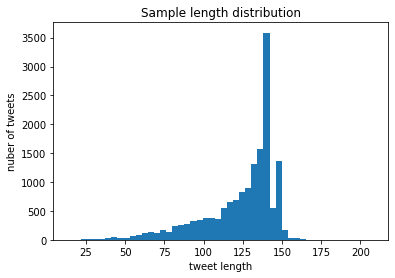

In [10]:
#distr. tweet lengths
def sample_plotter(text2):
    plt.hist([len(s) for s in text2], 50)
    plt.xlabel('tweet length')
    plt.ylabel('nuber of tweets')
    plt.title('Sample length distribution')
    plt.show()

sample_plotter(train['message'])

In [11]:
train.head()

sentiment                                            message  tweetid
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221
1          1  It's not like we lack evidence of anthropogeni...   126103
2          2  RT @RawStory: Researchers say we have three ye...   698562
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954

In [12]:
#word sample ratios
word_sample_ratio = sample_tot/words
print(round(word_sample_ratio, 0))

879.0


In [325]:
#sentiment prep
def adder(text):
    num = int(text)
    num = num + 1
    return num
train['sentiment'] = train['sentiment'].apply(adder)
train['sentiment'] = train['sentiment'].replace(3, 2)
train['sentiment']
y = train['sentiment'].values

In [299]:
#stop words
stop2 = text.ENGLISH_STOP_WORDS
stop = set(stopwords.words('english'))

In [18]:
X = train.iloc[:, 1].values
y = train.iloc[:, 0].values

In [ ]:
embeddings_index = {}
f = open(os.path.join('../glove-global-vectors-for-word-representation', 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

In [326]:
#test and train
from sklearn.model_selection import train_test_split
X, validation_x, Y, validation_y = train_test_split(x, y, test_size=0.30, shuffle = True, random_state=32)
train_text, test_text, train_val, test_val = train_test_split(X, Y, test_size=0.20, shuffle = True, random_state=32)



In [346]:
embeddings_dict = {}


with open("glove.twitter.27B.100d.txt", 'r', encoding = 'utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:])
        embeddings_dict[word] = vector


embedding_path = "glove.twitter.27B.100d.txt" 

def get_word2vec(file_path):
    file = open(embedding_path, "r", encoding = 'utf-8')
    if (file):
        word2vec = dict()
        split = file.read().splitlines()
        for line in split:
            key = line.split(' ',1)[0] # the first word is the key
            value = np.array([float(val) for val in line.split(' ')[1:]])
            word2vec[key] = value
        return (word2vec)
w2v = get_word2vec(embedding_path)

KeyboardInterrupt: 

In [348]:
embeddings_index = {}
with open("glove.twitter.27B.100d.txt", 'r', encoding = 'utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


In [350]:
word_index = token.word_index
print('Found %s unique tokens.' % len(word_index))

Found 13870 unique tokens.


In [356]:
num_words = min(20000, len(word_index)) + 1
em_mat = np.zeros((num_words, 100))
# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word_index.items():
    if i > 20000:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        em_mat[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        em_mat[i] = np.random.randn(100)

In [320]:
#tokenizing into uni+bi-grams and vectorizing
from sklearn.feature_extraction.text import TfidfTransformer


t_vector = TfidfVectorizer(ngram_range=(1, 2),
                            
                           strip_accents = 'unicode',
                           decode_error = 'replace',
                           analyzer = 'word',
                           min_df = .1, 
                           max_df = .50,
                           stop_words = stop)
x_train = t_vector.fit_transform(train_text)
x_val = t_vector.transform(test_text)

AttributeError: 'numpy.ndarray' object has no attribute 'lower'

In [327]:
#Selecting top 20 000 Features for n-gram model
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

b_vect = SelectKBest(f_classif, k = min(20000, train_text.shape[1]))
b_vect.fit(train_text, train_val)
train_text = b_vect.transform(train_text).astype('float32')
x_train = train_text
test_text = b_vect.transform(test_text).astype('float32')
x_val = test_text

In [328]:
x_train

array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 3.000e+00, 1.460e+02,
        1.000e+00],
       [4.000e+00, 7.710e+02, 7.710e+02, ..., 7.710e+02, 7.710e+02,
        2.744e+03],
       [1.000e+00, 1.000e+00, 3.100e+01, ..., 1.000e+00, 1.300e+01,
        2.467e+03],
       ...,
       [1.000e+00, 4.880e+02, 1.000e+00, ..., 1.000e+00, 4.460e+02,
        1.000e+00],
       [2.524e+03, 3.566e+03, 1.000e+00, ..., 1.000e+00, 3.630e+02,
        4.789e+03],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.000e+00, 2.000e+00,
        3.000e+00]], dtype=float32)

In [329]:
x_val

array([[4.000e+00, 7.070e+02, 1.570e+02, ..., 1.000e+00, 1.000e+00,
        1.000e+00],
       [0.000e+00, 0.000e+00, 4.000e+00, ..., 1.000e+00, 3.200e+01,
        7.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.000e+00, 1.000e+00,
        3.150e+02],
       ...,
       [1.000e+00, 1.800e+01, 1.000e+00, ..., 2.000e+00, 3.000e+00,
        4.275e+03],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.000e+00, 3.000e+00,
        1.000e+00],
       [1.000e+00, 2.000e+00, 3.000e+00, ..., 1.000e+00, 4.845e+03,
        1.000e+00]], dtype=float32)

In [377]:
#building  multilayer perceptron
#not optimized
from keras.layers import Embedding, Bidirectional, LSTM
from keras.initializers import Constant
drop_rate = 0.2
#layers = 2
clasif = models.Sequential()
clasif.add(Embedding(num_words,
                     100,
                     embeddings_initializer =Constant(em_mat),
                     input_length = 18,
                     trainable=True))
clasif.add(Dropout(rate = drop_rate, input_shape = x_train.shape[1:]))
#clasif.add(Bidirectional(LSTM(64, return_sequences = True)))
#clasif.add(Bidirectional(LSTM(32)))
clasif.add(Dropout(rate = 0.1))
clasif.add(Dense(units = 3,activation = 'softmax'))


#for lvl in range(layers - 1):
#    clasif.add(Dense(units = 3, activation = 'relu'))
#    clasif.add(Dropout(rate = 0.1))
#clasif.add(Dense(units = 3,activation = 'softmax'))

In [378]:
#N-gram model training and validation. Haven't used balance library
#Metrics calc for metrics not available in Keras. Funcs from Stackoverflow

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


optimizer = Adam(lr = 1e-3)
clasif.compile(optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['acc', f1_m, precision_m, recall_m])
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]
history = clasif.fit(
            x_train,
            train_val,
            epochs=1000,
            batch_size = 128,
            callbacks=callbacks,
            validation_data=(x_val, test_val),
            verbose=2,  # Logs once per epoch.
            )
history = history.history
print('Validation accuracy: {acc}, loss: {loss}, f1_score: {f1}'.format(acc=history['val_acc'][-1], loss=history['val_loss'][-1], f1 = history['val_f1_m']))

ValueError: Error when checking target: expected dense_13 to have 3 dimensions, but got array with shape (8858, 1)

In [341]:
from imblearn.over_sampling import KMeansSMOTE, ADASYN, SMOTE, BorderlineSMOTE, SVMSMOTE, SMOTENC, RandomOverSampler
from imblearn.pipeline import make_pipeline
from catboost import CatBoostClassifier
pipeline = make_pipeline(RandomOverSampler(random_state=32), CatBoostClassifier(depth=9, 
                                                                                bootstrap_type= 'Bayesian', 
                                                                                loss_function = 'MultiClass', 
                                                                                iterations=80, learning_rate=0.4, l2_leaf_reg=26))
pipeline.fit( x_train,
            train_val)

0:	learn: 1.0702214	total: 101ms	remaining: 8s
1:	learn: 1.0376314	total: 203ms	remaining: 7.93s
2:	learn: 1.0216949	total: 309ms	remaining: 7.93s
3:	learn: 0.9984164	total: 407ms	remaining: 7.73s
4:	learn: 0.9822195	total: 516ms	remaining: 7.73s
5:	learn: 0.9643367	total: 617ms	remaining: 7.61s
6:	learn: 0.9485583	total: 719ms	remaining: 7.5s
7:	learn: 0.9308092	total: 830ms	remaining: 7.47s
8:	learn: 0.9194750	total: 940ms	remaining: 7.41s
9:	learn: 0.9089587	total: 1.05s	remaining: 7.35s
10:	learn: 0.8988127	total: 1.16s	remaining: 7.27s
11:	learn: 0.8864199	total: 1.26s	remaining: 7.16s
12:	learn: 0.8749474	total: 1.37s	remaining: 7.04s
13:	learn: 0.8646275	total: 1.47s	remaining: 6.93s
14:	learn: 0.8558497	total: 1.57s	remaining: 6.8s
15:	learn: 0.8438211	total: 1.67s	remaining: 6.69s
16:	learn: 0.8334711	total: 1.77s	remaining: 6.58s
17:	learn: 0.8257156	total: 1.88s	remaining: 6.49s
18:	learn: 0.8171806	total: 1.99s	remaining: 6.38s
19:	learn: 0.8054038	total: 2.1s	remaining: 6.

Pipeline(steps=[('randomoversampler', RandomOverSampler(random_state=32)),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x0000028E22617908>)])

In [340]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
y_pred2 = pipeline.predict(test_text)
print(accuracy_score(test_val, y_pred2))
print(precision_score(test_val, y_pred2, average = 'macro'))
print(recall_score(test_val, y_pred2, average='macro'))
print(f1_score(test_val, y_pred2, average='macro'))

0.5986455981941309
0.42956292127270784
0.46846756140042295
0.4300050909468606


In [332]:
y_pred = clasif.predict_classes(validation_x)
score = f1_score(validation_y, y_pred, average='macro')
score

0.29179049632463167

In [58]:
train.head()

sentiment                                            message  tweetid
0          1  polyscimajor epa chief doesn't think carbon di...   625221
1          1  it's not like we lack evidence of anthropogeni...   126103
2          2  rt @rawstory: researchers say we have three ye...   698562
3          1  #todayinmaker# wired : 2016 was a pivotal year...   573736
4          1  rt @soynoviodetodas: it's 2016, and a racist, ...   466954

In [4]:
'''
Lowercaase, remove punct and numbers
'''
import string


def clean_text(text):
    # remove numbers
    text_nonum = re.sub(r'\d+', '', text)
    # remove punctuations and convert characters to lower case
    text_nopunct = "".join([char.lower() for char in text_nonum if char not in string.punctuation]) 
    # substitute multiple whitespace with single whitespace
    # Also, removes leading and trailing whitespaces
    text_no_doublespace = re.sub('\s+', ' ', text_nopunct).strip()
    return text_no_doublespace


'\ntrain[\'cleaned\'] = train[\'message\'].str.split()\nfor text in train[\'message\']:\n    text_nonum = re.sub(r\'\\d+\', \'\', text)\n    text_nopunct = "".join([char.lower() for char in text_nonum if char not in string.punctuation]) \n    text_no_doublespace = re.sub(\'\\s+\', \' \', text_nopunct).strip()\n    train[\'message\'] = text_no_doublespace\n'

In [59]:
train['message'] = train['message'].apply(clean_text)

In [60]:
def counter(text):
    # remove numbers
    count = len(text)
    return count
train['count'] = train['message'].apply(counter)
train.pop('tweetid')
train.head()

sentiment                                            message  count
0          1  polyscimajor epa chief doesnt think carbon dio...    128
1          1  its not like we lack evidence of anthropogenic...     61
2          2  rt rawstory researchers say we have three year...    125
3          1  todayinmaker wired was a pivotal year in the w...     83
4          1  rt soynoviodetodas its and a racist sexist cli...    109

In [ ]:
from nltk import word_tokenize
def tokenizer(text3):
    tokenized = word_tokenize(text3)
    return tokenized

In [ ]:
train['tokenized'] = train["message"].apply(tokenizer)

In [ ]:
train.head()

In [61]:
texts = train['message']

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95,
                                  stop_words = stop2)

x_train = tfidf_vectorizer.fit_transform(texts) #features

In [62]:
x_train.shape

(15819, 22505)

In [63]:
from sklearn.decomposition import TruncatedSVD 
lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

x_train = lsa.fit_transform(x_train)
x_train.shape

(15819, 100)

In [ ]:
'''
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df = 1, ngram_range = (1,1), 
                             stop_words = stop2)
tfidf = vectorizer.fit_transform(text4)
return tfidf
'''

In [ ]:
def cleaner_text(text2):
    tweet = [w for w in text2 if w not in list(stop2)]
    return tweet

In [ ]:
train['tokey'] = train['tokenized'].apply(cleaner_text)

In [ ]:
train.head()

In [ ]:
train['tokey2'] = train['tokenized'].apply(vect_funct)

In [ ]:
train.head()

In [64]:
y_train = train['sentiment'].values

In [65]:
from sklearn.model_selection import train_test_split
X_trainer, X_tester, y_trainer, y_tester = train_test_split(x_train, y_train, test_size=0.20, shuffle = True, random_state=32)

In [94]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from catboost import CatBoostClassifier

'''Metrics/Evaluation'''
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle

In [97]:
#Preliminary model evaluation using default parameters

#Creating a dict of the models
model_dict = {"CatBoost" : CatBoostClassifier(depth=9,
                                              bootstrap_type= 'Bayesian', 
                                              loss_function = 'MultiClass', 
                                              iterations=80, learning_rate=0.4, 
                                              l2_leaf_reg=26),
              "SVC": SVC(max_iter = 100, kernel =  'linear' ),
              'Random Forest': RandomForestClassifier(random_state=32),
              'K Nearest Neighbor': KNeighborsClassifier()}



#Function to get the scores for each model in a df
def model_score_df(model_dict):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_trainer, y_trainer)
        y_pred = v.predict(X_tester)
        ac_score_list.append(accuracy_score(y_tester, y_pred))
        p_score_list.append(precision_score(y_tester, y_pred, average='macro'))
        r_score_list.append(recall_score(y_tester, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_tester, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df

model_score_df(model_dict)

0:	learn: 1.2422782	total: 651ms	remaining: 51.4s
1:	learn: 1.1629784	total: 1.42s	remaining: 55.3s
2:	learn: 1.1074635	total: 2.17s	remaining: 55.7s
3:	learn: 1.0648235	total: 2.87s	remaining: 54.6s
4:	learn: 1.0378812	total: 3.65s	remaining: 54.7s
5:	learn: 1.0103706	total: 4.41s	remaining: 54.3s
6:	learn: 0.9892448	total: 5.15s	remaining: 53.7s
7:	learn: 0.9673001	total: 5.84s	remaining: 52.6s
8:	learn: 0.9526841	total: 6.54s	remaining: 51.6s
9:	learn: 0.9375668	total: 7.26s	remaining: 50.9s
10:	learn: 0.9256460	total: 7.95s	remaining: 49.9s
11:	learn: 0.9127509	total: 8.65s	remaining: 49s
12:	learn: 0.9020729	total: 9.34s	remaining: 48.1s
13:	learn: 0.8913362	total: 10s	remaining: 47.3s
14:	learn: 0.8830024	total: 10.7s	remaining: 46.4s
15:	learn: 0.8742813	total: 11.4s	remaining: 45.6s
16:	learn: 0.8646963	total: 12.1s	remaining: 44.8s
17:	learn: 0.8560204	total: 12.8s	remaining: 44.1s
18:	learn: 0.8476133	total: 13.5s	remaining: 43.2s
19:	learn: 0.8417029	total: 14.2s	remaining: 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


model_name accuracy_score precision_score recall_score  f1_score
2       Random Forest       0.696903        0.692982     0.505798   0.54071
0            CatBoost       0.678887        0.640671     0.499413  0.529377
3  K Nearest Neighbor       0.605879        0.510207     0.502339  0.505625
1                 SVC       0.541719        0.430299     0.282851  0.252387

In [70]:
pip install -U imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [91]:
from imblearn.over_sampling import KMeansSMOTE, ADASYN, SMOTE, BorderlineSMOTE, SVMSMOTE, SMOTENC, RandomOverSampler
from imblearn.pipeline import make_pipeline
pipeline = make_pipeline(RandomOverSampler(random_state=32), CatBoostClassifier(depth=9, 
                                                                                bootstrap_type= 'Bayesian', 
                                                                                loss_function = 'MultiClass', 
                                                                                iterations=80, learning_rate=0.4, l2_leaf_reg=26))
pipeline.fit(X_trainer, y_trainer)

0:	learn: 1.2901965	total: 724ms	remaining: 57.2s
1:	learn: 1.2176739	total: 1.5s	remaining: 58.6s
2:	learn: 1.1640547	total: 2.23s	remaining: 57.2s
3:	learn: 1.1205991	total: 2.95s	remaining: 56.1s
4:	learn: 1.0851678	total: 3.67s	remaining: 55s
5:	learn: 1.0547703	total: 4.38s	remaining: 54.1s
6:	learn: 1.0258817	total: 5.12s	remaining: 53.4s
7:	learn: 1.0036852	total: 5.83s	remaining: 52.4s
8:	learn: 0.9882438	total: 6.52s	remaining: 51.5s
9:	learn: 0.9647969	total: 7.25s	remaining: 50.8s
10:	learn: 0.9507624	total: 7.95s	remaining: 49.9s
11:	learn: 0.9309737	total: 8.67s	remaining: 49.2s
12:	learn: 0.9151370	total: 9.39s	remaining: 48.4s
13:	learn: 0.8982678	total: 10.1s	remaining: 47.7s
14:	learn: 0.8830705	total: 10.8s	remaining: 47s
15:	learn: 0.8697233	total: 11.5s	remaining: 46.2s
16:	learn: 0.8522023	total: 12.3s	remaining: 45.5s
17:	learn: 0.8431209	total: 13s	remaining: 44.6s
18:	learn: 0.8340374	total: 13.6s	remaining: 43.7s
19:	learn: 0.8248791	total: 14.3s	remaining: 43s

Pipeline(steps=[('randomoversampler', RandomOverSampler(random_state=32)),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x000002091C577908>)])

In [ ]:
y_pred2 = pipeline.predict(X_tester)
print(accuracy_score(y_tester, y_pred2))
print(precision_score(y_tester, y_pred2, average = 'macro'))
print(recall_score(y_tester, y_pred2, average='macro'))
print(f1_score(y_tester, y_pred2, average='macro'))

In [92]:
#RandomOverSampler
y_pred2 = pipeline.predict(X_tester)
print(accuracy_score(y_tester, y_pred2))
print(precision_score(y_tester, y_pred2, average = 'macro'))
print(recall_score(y_tester, y_pred2, average='macro'))
print(f1_score(y_tester, y_pred2, average='macro'))

0.6254740834386852
0.5295210551142089
0.5607691006775947
0.5411830007069668


In [86]:
#SVMSMOTE
y_pred2 = pipeline.predict(X_tester)
print(accuracy_score(y_tester, y_pred2))
print(precision_score(y_tester, y_pred2, average = 'macro'))
print(recall_score(y_tester, y_pred2, average='macro'))
print(f1_score(y_tester, y_pred2, average='macro'))

0.6343236409608091
0.5440021456026725
0.5640358371482043
0.5496275062157618


In [84]:
#BorderlineSMOTE
y_pred2 = pipeline.predict(X_tester)
print(accuracy_score(y_tester, y_pred2))
print(precision_score(y_tester, y_pred2, average = 'macro'))
print(recall_score(y_tester, y_pred2, average='macro'))
print(f1_score(y_tester, y_pred2, average='macro'))

0.618204804045512
0.5242842856455125
0.564490887377282
0.5378716428178781


In [82]:
#KMeansSMOTE
y_pred2 = pipeline.predict(X_tester)
print(accuracy_score(y_tester, y_pred2))
print(precision_score(y_tester, y_pred2, average = 'macro'))
print(recall_score(y_tester, y_pred2, average='macro'))
print(f1_score(y_tester, y_pred2, average='macro'))

0.654551201011378
0.6587153718983736
0.4963123641656133
0.5128128953008306


In [80]:
#SMOTE
y_pred2 = pipeline.predict(X_tester)
print(accuracy_score(y_tester, y_pred2))
print(precision_score(y_tester, y_pred2, average = 'macro'))
print(recall_score(y_tester, y_pred2, average='macro'))
print(f1_score(y_tester, y_pred2, average='macro'))

0.6219974715549936
0.5327266928984817
0.5775695142430038
0.5476057043805225


In [78]:
#ADSYN
y_pred2 = pipeline.predict(X_tester)
print(accuracy_score(y_tester, y_pred2))
print(precision_score(y_tester, y_pred2, average = 'macro'))
print(recall_score(y_tester, y_pred2, average='macro'))
print(f1_score(y_tester, y_pred2, average='macro'))

0.6103034134007586
0.5262459074497435
0.5765977308632997
0.5413008411586501


In [ ]:
print("\n The best estimator across ALL searched params:\n", randm.best_estimator_)
    
print("\n The best score across ALL searched params:\n", randm.best_score_)
    
print("\n The best parameters across ALL searched params:\n", randm.best_params_)

In [ ]:
model = CatBoostClassifier()
parameters = {'depth': list(range(4, 10, 1)),
              
              'iterations': list(range(10, 100, 10))}
    
randm = GridSearchCV(estimator=model, param_grid = parameters, cv = 2,  n_jobs=-1)
randm.fit(X_trainer, y_trainer)

In [19]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
model = CatBoostClassifier(depth=9, iterations=80, learning_rate=0.4, l2_leaf_reg=26)
parameters = {'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS', 'Poisson'],
              
              'loss_function': ['Logloss', 'CrossEntropy', 'MultiClassOneVsAll', 'MAPE', 'MultiClass']}
randm = GridSearchCV(estimator=model, param_grid = parameters, cv = 2,  n_jobs=-1)
randm.fit(X_trainer, y_trainer)

    # Results from Random Search
    

0:	learn: 1.2713026	total: 734ms	remaining: 58s
1:	learn: 1.1741230	total: 1.41s	remaining: 55.1s
2:	learn: 1.1301406	total: 2.11s	remaining: 54.3s
3:	learn: 1.0856734	total: 2.81s	remaining: 53.3s
4:	learn: 1.0589595	total: 3.47s	remaining: 52.1s
5:	learn: 1.0343295	total: 4.17s	remaining: 51.4s
6:	learn: 1.0129892	total: 4.85s	remaining: 50.6s
7:	learn: 0.9950448	total: 5.51s	remaining: 49.6s
8:	learn: 0.9781915	total: 6.22s	remaining: 49.1s
9:	learn: 0.9629398	total: 6.91s	remaining: 48.4s
10:	learn: 0.9517231	total: 7.6s	remaining: 47.7s
11:	learn: 0.9404595	total: 8.31s	remaining: 47.1s
12:	learn: 0.9301228	total: 8.99s	remaining: 46.3s
13:	learn: 0.9191849	total: 9.69s	remaining: 45.7s
14:	learn: 0.9096659	total: 10.4s	remaining: 44.9s
15:	learn: 0.9001949	total: 11.1s	remaining: 44.3s
16:	learn: 0.8914413	total: 11.8s	remaining: 43.7s
17:	learn: 0.8819735	total: 12.5s	remaining: 43s
18:	learn: 0.8743611	total: 13.2s	remaining: 42.3s
19:	learn: 0.8650124	total: 13.9s	remaining: 4

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostClassifier object at 0x00000299295B69C8>,
             n_jobs=-1,
             param_grid={'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS',
                                            'Poisson'],
                         'loss_function': ['Logloss', 'CrossEntropy',
                                           'MultiClassOneVsAll', 'MAPE',
                                           'MultiClass']})

In [20]:
print("\n The best estimator across ALL searched params:\n", randm.best_estimator_)
    
print("\n The best score across ALL searched params:\n", randm.best_score_)
    
print("\n The best parameters across ALL searched params:\n", randm.best_params_)
    


 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.6530229868900106

 The best parameters across ALL searched params:
 {'bootstrap_type': 'Bayesian', 'loss_function': 'MultiClass'}


In [32]:
print(accuracy_score(y_tester, y_pred)
print(precision_score(y_tester, y_pred, average='macro')
print(recall_score(y_tester, y_pred, average='macro')
f1_score = f1_score(y_tester, y_pred)
print(ac_score)
print(p_score)
print(r_score)
print(f1_score)

TypeError: 'numpy.float64' object is not callable

In [22]:
model = CatBoostClassifier(depth=9, bootstrap_type= 'Bayesian', loss_function = 'MultiClass', iterations=80, learning_rate=0.4, l2_leaf_reg=26)
model.fit(X_trainer, y_trainer)
y_pred = model.predict(X_tester)
ac_score = (accuracy_score(y_tester, y_pred))
p_score = (precision_score(y_tester, y_pred, average='macro'))
r_score = (recall_score(y_tester, y_pred, average='macro'))
f1_score = (f1_score(y_tester, y_pred, average='macro'))
print(ac_score)
print(p_score)
print(r_score)
print(f1_score)

0:	learn: 1.2713026	total: 669ms	remaining: 52.8s
1:	learn: 1.1741230	total: 1.35s	remaining: 52.5s
2:	learn: 1.1301406	total: 2.03s	remaining: 52.1s
3:	learn: 1.0856734	total: 2.72s	remaining: 51.7s
4:	learn: 1.0589595	total: 3.42s	remaining: 51.3s
5:	learn: 1.0343295	total: 4.09s	remaining: 50.5s
6:	learn: 1.0129892	total: 4.77s	remaining: 49.8s
7:	learn: 0.9950448	total: 5.46s	remaining: 49.1s
8:	learn: 0.9781915	total: 6.14s	remaining: 48.5s
9:	learn: 0.9629398	total: 6.82s	remaining: 47.8s
10:	learn: 0.9517231	total: 7.49s	remaining: 47s
11:	learn: 0.9404595	total: 8.16s	remaining: 46.2s
12:	learn: 0.9301228	total: 8.83s	remaining: 45.5s
13:	learn: 0.9191849	total: 9.52s	remaining: 44.9s
14:	learn: 0.9096659	total: 10.2s	remaining: 44.2s
15:	learn: 0.9001949	total: 10.9s	remaining: 43.6s
16:	learn: 0.8914413	total: 11.6s	remaining: 42.8s
17:	learn: 0.8819735	total: 12.2s	remaining: 42.1s
18:	learn: 0.8743611	total: 12.9s	remaining: 41.4s
19:	learn: 0.8650124	total: 13.6s	remaining

NameError: name 'accuracy_score' is not defined

In [232]:
from sklearn.model_selection import GridSearchCV
model = CatBoostClassifier(depth=9, iterations=80)
parameters = {'learning_rate': [0.6, 0.1, 0.4, 0.8],
               'l2_leaf_reg': list(range(2, 30, 2))}
    
randm = GridSearchCV(estimator=model, param_grid = parameters, cv = 2,  n_jobs=-1)
randm.fit(X_trainer, y_trainer)


0:	learn: 1.2713026	total: 698ms	remaining: 55.1s
1:	learn: 1.1741230	total: 1.38s	remaining: 53.9s
2:	learn: 1.1301406	total: 2.09s	remaining: 53.7s
3:	learn: 1.0856734	total: 2.79s	remaining: 53s
4:	learn: 1.0589595	total: 3.48s	remaining: 52.3s
5:	learn: 1.0343295	total: 4.18s	remaining: 51.5s
6:	learn: 1.0129892	total: 4.88s	remaining: 50.9s
7:	learn: 0.9950448	total: 5.57s	remaining: 50.2s
8:	learn: 0.9781915	total: 6.26s	remaining: 49.4s
9:	learn: 0.9629398	total: 6.96s	remaining: 48.7s
10:	learn: 0.9517231	total: 7.65s	remaining: 48s
11:	learn: 0.9404595	total: 8.34s	remaining: 47.2s
12:	learn: 0.9301228	total: 9.03s	remaining: 46.5s
13:	learn: 0.9191849	total: 9.73s	remaining: 45.9s
14:	learn: 0.9096659	total: 10.4s	remaining: 45.2s
15:	learn: 0.9001949	total: 11.1s	remaining: 44.4s
16:	learn: 0.8914413	total: 11.8s	remaining: 43.7s
17:	learn: 0.8819735	total: 12.5s	remaining: 43.1s
18:	learn: 0.8743611	total: 13.2s	remaining: 42.3s
19:	learn: 0.8650124	total: 13.9s	remaining: 

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000023789970288>,
             n_jobs=-1,
             param_grid={'l2_leaf_reg': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22,
                                         24, 26, 28],
                         'learning_rate': [0.6, 0.1, 0.4, 0.8]})

In [233]:
print("\n The best estimator across ALL searched params:\n", randm.best_estimator_)
    
print("\n The best score across ALL searched params:\n", randm.best_score_)
    
print("\n The best parameters across ALL searched params:\n", randm.best_params_)
    


 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.6530229868900106

 The best parameters across ALL searched params:
 {'l2_leaf_reg': 26, 'learning_rate': 0.4}


In [229]:
print("\n The best estimator across ALL searched params:\n", randm.best_estimator_)
    
print("\n The best score across ALL searched params:\n", randm.best_score_)
    
print("\n The best parameters across ALL searched params:\n", randm.best_params_)
    


 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.6437770235802374

 The best parameters across ALL searched params:
 {'depth': 9, 'iterations': 80}
